In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms, utils
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
import numpy as np

import os
import glob

In [2]:
# Set up cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# Select whether you are running on Google Collab ('collab') or locally ('local')
system = 'local'
s = os.sep

if system == 'collab':
    # Mount google drive
    from google.colab import drive
    drive.mount(f'{s}content{s}drive')

    root_path = f'{s}content{s}drive{s}My Drive{s}Collab Data{s}Chest X-Ray{s}chest_xray'
    
elif system == 'local':
    root_path =f'../{s}data{s}chest_xray'
    
if os.path.isdir(root_path):
    print('Data folder exists')
else:
    print('Data folder doesnt exist')

Data folder exists


In [37]:
class XrayDataset(Dataset):
  '''
  Args:
    root_dir : path to the directory which contains the NORMAL/PNEMONIA split
    transform : transforms to be applied to each image
  '''
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.samples = []
    self.transform = transform

    for label in os.listdir(root_dir):
      label_folder = os.path.join(root_dir, label)
      
      for image_path in os.listdir(label_folder):
        self.samples.append((os.path.join(label_folder, image_path), label))

  def __len__(self):
        return len(self.samples)

  def __getitem__(self, idx):
    
    if torch.is_tensor(idx):
      idx = idx.tolist()

    im_path, label = self.samples[idx]

    im = Image.open(im_path)
    
    if im.mode == 'L':
      im = im.convert('RGB')
    
    if self.transform:
      im = self.transform(im)
      
    classes = {'PNEUMONIA': 1.0, 'NORMAL': 0.0}
    return {'image': im, 'class': classes[label], 'path': im_path}


In [44]:
bs = 1

transform = transforms.Compose([transforms.RandomResizedCrop((255,255)),
                                transforms.ToTensor()])
test = XrayDataset(os.path.join(root_path, 'train'), transform=transform)
dl = DataLoader(test, 
                batch_size=bs,
                shuffle=True)

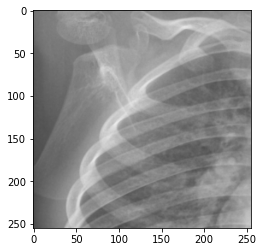

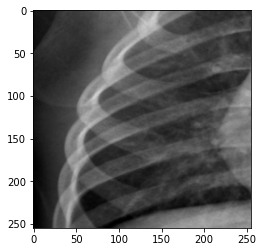

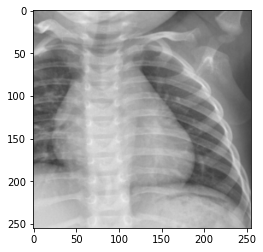

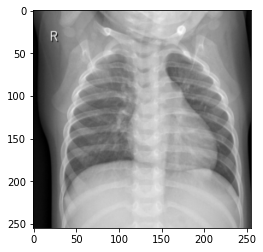

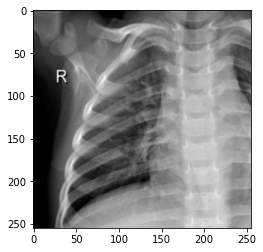

In [45]:
# Show some of the images
b=0
for i in iter(test):
  b += 1
  plt.imshow(i['image'].permute(1, 2, 0))
  plt.show()
  if b == 5:
    break

In [58]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(60 * 60 * 16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10,1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 60 * 60 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [59]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=57600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)

In [60]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [61]:
# Training loop

losses = []

running_loss = 0
epochs = 5

for j in range(epochs):
    for i, data_dic in enumerate(dl):
      optimizer.zero_grad()

      data, labels = data_dic['image'].to(device), data_dic['class'].to(device)
      outputs = net(data).view(-1)

      loss = criterion(outputs, labels.float())
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      losses.append(loss.item())

      if i % 50 == 49:
          print('[%d,%5d] loss: %.3f' %(j + 1, i + 1, running_loss/50))
          running_loss = 0

[1,   50] loss: 0.587
[1,  100] loss: 0.266
[1,  150] loss: 0.189
[1,  200] loss: 0.233
[1,  250] loss: 0.208
[1,  300] loss: 0.197
[1,  350] loss: 0.155
[1,  400] loss: 0.176
[1,  450] loss: 0.221
[1,  500] loss: 0.178
[1,  550] loss: 0.196
[1,  600] loss: 0.196
[1,  650] loss: 0.187
[1,  700] loss: 0.207
[1,  750] loss: 0.233
[1,  800] loss: 0.154
[1,  850] loss: 0.175
[1,  900] loss: 0.207
[1,  950] loss: 0.185
[1, 1000] loss: 0.165
[1, 1050] loss: 0.249
[1, 1100] loss: 0.157
[1, 1150] loss: 0.207
[1, 1200] loss: 0.195
[1, 1250] loss: 0.251
[1, 1300] loss: 0.228
[1, 1350] loss: 0.190
[1, 1400] loss: 0.163
[1, 1450] loss: 0.219
[1, 1500] loss: 0.213
[1, 1550] loss: 0.158
[1, 1600] loss: 0.252
[1, 1650] loss: 0.113
[1, 1700] loss: 0.226
[1, 1750] loss: 0.153
[1, 1800] loss: 0.185
[1, 1850] loss: 0.236
[1, 1900] loss: 0.197
[1, 1950] loss: 0.190
[1, 2000] loss: 0.194
[1, 2050] loss: 0.163
[1, 2100] loss: 0.185
[1, 2150] loss: 0.238
[1, 2200] loss: 0.198
[1, 2250] loss: 0.142
[1, 2300] 

KeyboardInterrupt: 

In [ ]:
# We can graph accuracy and loss here